# 03 Creating a Site Density Map

Next we want to generate a function to help us create a local map of site densities so that we can go back to our favorite spots and extend the finds without wasting too much time and boot leather


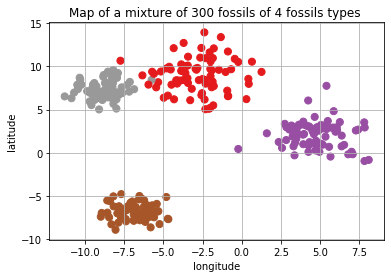

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets import make_blobs
n_components = 4
X, truth = make_blobs(n_samples=300, centers=n_components, 
                      cluster_std = [2, 1.5, 1, 1], 
                      random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=50, c = truth, cmap='Set1')
plt.title(f"Map of a mixture of 300 fossils of {n_components} fossils types ")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.grid()

NameError: name 'X' is not defined

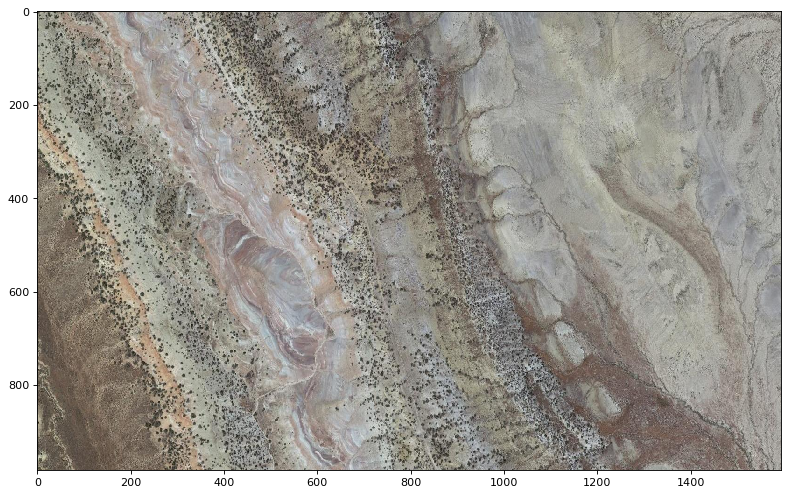

In [1]:
from matplotlib.pyplot import figure
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

figure(figsize=(12, 12), dpi=80)

NM = 'data/SomeWhereColorado.png'
img = Image.open(NM)
implot = plt.imshow(img)

# Map X coordinates to Image Coordinates

MapCoords = []
MapCoords.append(X[:,0].min() )
MapCoords.append(X[:,0].max() )
MapCoords.append(X[:,1].min() )
MapCoords.append(X[:,1].max() )
MapCoords = np.array(MapCoords)

ImageCoords = []
ImageCoords.append(0)
ImageCoords.append(img.size[0] )
ImageCoords.append(img.size[1])
ImageCoords.append(0 )
ImageCoords = np.array(ImageCoords)

MapX = LinearRegression().fit(MapCoords[:2].reshape(-1,1), ImageCoords[:2].reshape(-1,1))
PX = (MapX.predict(X[:,0].reshape(-1,1))).astype(int).squeeze() 
MapX = LinearRegression().fit(MapCoords[2:].reshape(-1,1), ImageCoords[2:].reshape(-1,1))
PY = (MapX.predict(X[:,1].reshape(-1,1))).astype(int).squeeze()
plt.scatter(PX,PY, c= 'lime')

# Generate Kernel Density Plot

In [3]:
import scipy.stats as st
# Kernel density, limits are extent of bone finds

BW = .5    # to specify BW
#BW = None  # to use auto BW

# Extract x and y
x = PX # n_samples is number of bone locations ~ 5000
y = PY # n_samples is number of bone locations ~ 5000

# image corners
xmin, ymin = 0, 0
xmax, ymax = img.size
inc = 1  #16x14 = 224 is multiple of 16

ymax = ymax//inc*inc

# Create meshgrid

#xx, yy = np.mgrid[xmin:xmax:inc, ymax:ymin:-inc]
xx, yy = np.mgrid[xmin:xmax+inc:inc, ymin:ymax+inc:inc]
yy = ymax - yy

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

if BW == None:
    kernel = st.gaussian_kde(values)
else:
    kernel = st.gaussian_kde(values, bw_method = BW)

f = np.reshape(kernel(positions), xx.shape)
z = f/f.max()

# Superimpose Site Density and Image

Image coordinate:  (800, 600)
Likelyhood:  0.4386192058274956


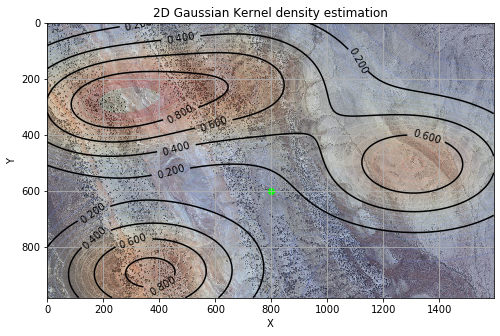

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
# xmax, ymax = 10100, 10256
# xmin, ymin = 0,0
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymax, ymin )

cfset = ax.contourf(xx, yy, z, cmap='coolwarm', levels=[i/20 for i in range (20)], alpha =.2)
#cfset = ax.contourf(xx, yy, z, cmap='coolwarm', levels= 3, alpha =.2)
ax.imshow(np.rot90(z), cmap='coolwarm', extent=[xmin, xmax, ymax, ymin  ])

#cset = ax.contour(xx, yy, z, colors='k')
cset = ax.contour(xx, yy, z, levels = 5, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

implot = plt.imshow(img)

# plot a sample piont in lime and read it density
X,Y = (800, 600)
plt.scatter(X, Y,c='lime')
plt.grid()

print("Image coordinate: ", (X,Y))
print('Likelyhood: ', z[X,Y])

# Image Patches: Method 1: 

### Possible Bone Locations (near Known Bone Locations)
- Pull Image Patch from sampling location

Its label will correspond to its density

label at (800, 600) = 0.4


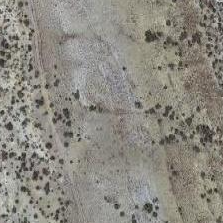

In [5]:
px = 800
py = 600
print(f"label at ({px}, {py}) = {z[px,py]:3.1f}")
# Note that the crop region must be given as a 4-tuple 
# (left, upper, right, lower).


crop_rectangle = (px - 112, py - 112, px + 111, py + 111)
cropped_im = img.crop(crop_rectangle)

cropped_im.show()


# Image Patches: Method 2: 

### Known Bone Loations
- Pull Image Patch from known bone location

It's label will be the maximum label score

label at (162, 303) = 1.0 by definition we found bone at this site!


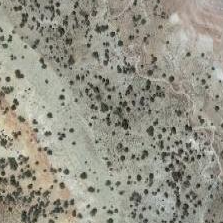

In [6]:
px, py = PX[42], PY[42]

print(f"label at ({px}, {py}) = 1.0 by definition we found bone at this site!")
# Note that the crop region must be given as a 4-tuple 
# (left, upper, right, lower).


crop_rectangle = (px - 112, py - 112, px + 111, py + 111)
cropped_im = img.crop(crop_rectangle)

cropped_im.show()


# Image Patches: Method 3: 

### Non Bone Locations
- Pull Image Patch from obviously NON Bone Locations
- Consult geological map **[National Geological Map Database](https://ngmdb.usgs.gov/mapview/?center=-109.308,40.436&zoom=14)** to find regions NOT in known bone beds: For **NON BONE** locations choose images AWAY from Jurassic Morrison formation and other famous bone beds such as the **"Hell Creek"** formation in the western US, **"Flaming Cliffs"** Formation in China, **"Lance Creek"** & **"Judith River"** in North America, etc. Avoid selecting images from KNOWN bones beds - NGMDB with regions starting with "J" or "K". "J" stands for Jurassic. "K" stands for cretaceous. For instance, near Dinosaur National Monument the designation Kjcm means this band belongs at the interface of Jurassic Morrison and Creatceous Cedar Mountain. This is a known bone bed generally - so do not choose these images for the NON Bone class!

**Note:**

In case you are wondering - YES - you could use maps such as these from NGMDB to label various bone beds!  But the map we create goes a step further and identifies more specific image textures WITHIN one of these formations!

![assets/National Geological Map Database for Dinosaur National Monument](assets/NGMDB_DNM.jpg)


Text(0.5, 1.0, 'Haystack Rock: No Bones here!')

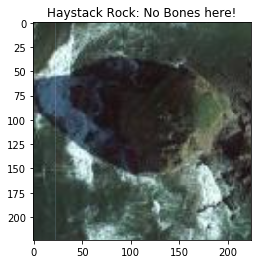

In [7]:
img = Image.open('data/OregonCoastHaystackRock.PNG')
implot = plt.imshow(img)
plt.title("Haystack Rock: No Bones here!")

# Sample and Save 224x224 Image Patches

Sample images for classes 2 = Bone, 0 = Non Bone, and 1 = Bone Possible

Write the 224x224 image patches to the folder structure as follows:

![assets/Folder Structre](assets/FolderStructure.jpg)